# Статистические тесты в контексте EDA #

Описание задания и решение приведены в README-файле по ссыдке:    
[https://github.com/stalkspectrum/sf-ds-course-all/blob/master/03-34-EDA-4/EDA4_Task/README.md](https://github.com/stalkspectrum/sf-ds-course-all/blob/master/03-34-EDA-4/EDA4_Task/README.md)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка и обработка данных ##

In [28]:
main_df = pd.read_csv('salaries.csv')
copy_df = main_df.copy()    # Резервная копия для дополнительных исследований
display(main_df.head())

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


##### Проверка наличия пустых ячеек по признакам: #####

In [29]:
main_df.isnull().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

#### Проверка наличия дубликатов: ####

In [30]:
print(f'Найдено дубликатов - {main_df[main_df.duplicated].shape[0]}')

Найдено дубликатов - 0


Пустот и дубликатов не обнаружено, теперь можно сразу избавиться от
неинформативных признаков.

Первая колонка **`Unnamed: 0`**&nbsp;&mdash; просто порядковый номер, явно
неинформативный.

Стоит ли удалять зарплату в национальных валютах **`salary`**?

In [31]:
main_df[['salary', 'salary_in_usd']].corr()

,salary,salary_in_usd
salary,1.000000,-0.083906
salary_in_usd,-0.083906,1.000000


Если подходить формально, признаки **`salary`** и **`salary_in_usd`** показывают
очень слабую корреляцию. Однако если построить график соотношения зарплаты в
национальных валютах (`salary`) к зарплате в долларах США (`salary_in_usd`) хотя
бы для самых популярных валют помимо доллара США:

In [32]:
main_df.salary_currency.value_counts().nlargest(5)

salary_currency
USD    398
EUR     95
GBP     44
INR     27
CAD     18
Name: count, dtype: int64

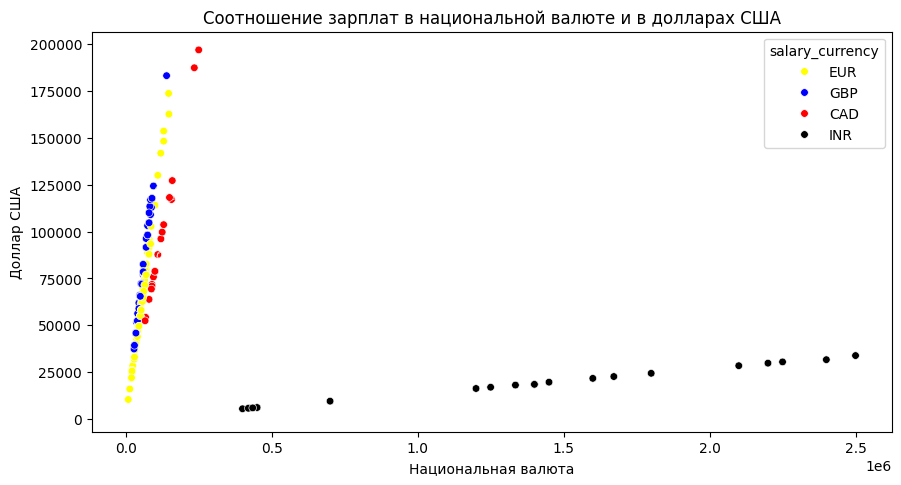

In [33]:
fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
tmp_df = main_df[(main_df['salary'] <= 2500000)]
sns.scatterplot(
    data=tmp_df[tmp_df['salary_currency'] != 'USD'],
    x='salary',
    y='salary_in_usd',
    hue='salary_currency',
    hue_order=['EUR', 'GBP', 'CAD', 'INR'],
    palette={'EUR': 'yellow', 'GBP': 'blue', 'CAD': 'red', 'INR': 'black'},
    s=30,
    ax=axes
)
axes.set_title('Соотношение зарплат в национальной валюте и в долларах США')
axes.set_xlabel('Национальная валюта')
axes.set_ylabel('Доллар США');

Видно, что по каждой валюте зависимость получается практически прямой
(плюс-минус годовые колебания курсов), что означает очень сильную корреляцию.
Это можно показать численно по каждой валюте, например по евро:

In [39]:
main_df[main_df.salary_currency == 'EUR'][['salary', 'salary_in_usd']].corr()

,salary,salary_in_usd
salary,1.00000,0.99733
salary_in_usd,0.99733,1.00000


Так что можно вполне обоснованно вместе с **`Unnamed: 0`** отбросить признаки
**`salary`** и сопутствующий ему **`salary_currency`**:

In [6]:
main_df.drop(['Unnamed: 0', 'salary', 'salary_currency'], axis='columns', inplace=True)

##### Проверка корректности типов данных #####

In [7]:
display(main_df.info())
print(f'В признаке "work_year" уникальных значений - {main_df.work_year.nunique()}')
print(list(main_df.work_year.unique()))
print(f'В признаке "remote_ratio" уникальных значений - {main_df.remote_ratio.nunique()}')
print(list(main_df.remote_ratio.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary_in_usd       607 non-null    int64 
 5   employee_residence  607 non-null    object
 6   remote_ratio        607 non-null    int64 
 7   company_location    607 non-null    object
 8   company_size        607 non-null    object
dtypes: int64(3), object(6)
memory usage: 42.8+ KB


None

В признаке "work_year" уникальных значений - 3
[2020, 2021, 2022]
В признаке "remote_ratio" уникальных значений - 3
[0, 50, 100]


В числовых признаках **`work_year`** и **`remote_ratio`** только по три уникальных значения, поэтому их можно смело преобразовать в категориальные. Таким образом останется только один числовой непрерывный признак **`salary_in_usd`**.

In [8]:
def set_remote_category(per_cent: int) -> str:
    ''' Преобразует числовой процент удалённой работы в строковую
        категорию no-remote/part-remote/full-remote
    Arguments:
        per_cent [int] -- Доля удалённой работы в процентах
    Returns:
        [str] -- Категория no-remote/part-remote/full-remote
    '''
    if per_cent < 20:
        return 'no-remote'
    elif per_cent > 80:
        return 'full-remote'
    else:
        return 'part-remote'

# Преобразование work_year
main_df.work_year = main_df.work_year.apply(lambda x: str(x))
# Преобразование remote_ratio
main_df.remote_ratio = main_df.remote_ratio.apply(set_remote_category)

##### Проверка числа категорий по признакам #####

In [9]:
main_df.describe(include=['object'])

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,607,607,607,607,607,607,607,607
unique,3,4,4,50,57,3,50,3
top,2022,SE,FT,Data Scientist,US,full-remote,US,M
freq,318,280,588,143,332,381,355,326


Необходимо сократить число категорий в признаках **`job_title`**, **`employee_residence`** и **`company_location`**.

Посмотрим признак **`job_title`**:

In [10]:
main_df.job_title.value_counts().nlargest(10)

job_title
Data Scientist                143
Data Engineer                 132
Data Analyst                   97
Machine Learning Engineer      41
Research Scientist             16
Data Science Manager           12
Data Architect                 11
Big Data Engineer               8
Machine Learning Scientist      8
Principal Data Scientist        7
Name: count, dtype: int64

В признаке **`job_title`** для дальнейшего анализа нас будут интересовать только роли **`Data Scientist`** и **`Data Engineer`**. К тому же они составляют около половины датасета. Остальные роли можно объединить в одну **`Other`**.

In [11]:
main_df.job_title = main_df.job_title.apply(lambda x: x if x in ['Data Scientist',
                                                                 'Data Engineer']
                                                      else 'Other')

Теперь посмотрим признак **`employee_residence`**:

In [12]:
main_df.employee_residence.value_counts().nlargest(10)

employee_residence
US    332
GB     44
IN     30
CA     29
DE     25
FR     18
ES     15
GR     13
JP      7
PT      6
Name: count, dtype: int64

В признаке **`employee_residence`** больше половины сотрудников работают в США. Поэтому этот признак можно свести к двум категориям: **`US`** и **`Other`**.

In [13]:
main_df.employee_residence = main_df.employee_residence.apply(lambda x: x if x == 'US'
                                                                        else 'Other')

Аналогично смотрим признак **`company_location`**:

In [14]:
main_df.company_location.value_counts().nlargest(10)

company_location
US    355
GB     47
CA     30
DE     28
IN     24
FR     15
ES     14
GR     11
JP      6
NL      4
Name: count, dtype: int64

И в признаке **`company_location`** также оставляем только две категории: **`US`** и **`Other`**:

In [15]:
main_df.company_location = main_df.company_location.apply(lambda x: x if x == 'US'
                                                                    else 'Other')

##### Основная статистика по числовому признаку #####

In [16]:
main_df.salary_in_usd.describe()

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

##### Итоговая статистика по категориальным признакам #####

In [17]:
main_df.describe(include=['object'])

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,607,607,607,607,607,607,607,607
unique,3,4,4,3,2,3,2,3
top,2022,SE,FT,Other,US,full-remote,US,M
freq,318,280,588,332,332,381,355,326


## 2. Разведывательный анализ данных ##

### 2.1. Визуальный анализ данных ###

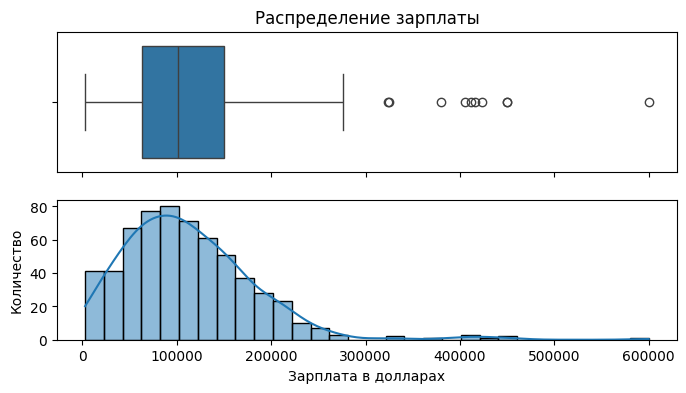

In [70]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 4), sharex=True)
sns.boxplot(
    data=main_df.salary_in_usd,
    orient='h',
    ax=ax1
)
sns.histplot(
    data=main_df['salary_in_usd'],
    bins=30,
    kde=True,
    legend=False,
    ax=ax2
)
ax1.set_title('Распределение зарплаты')
ax1.set_xlabel('')
ax2.set_xlabel('Зарплата в долларах')
ax2.set_ylabel('Количество');

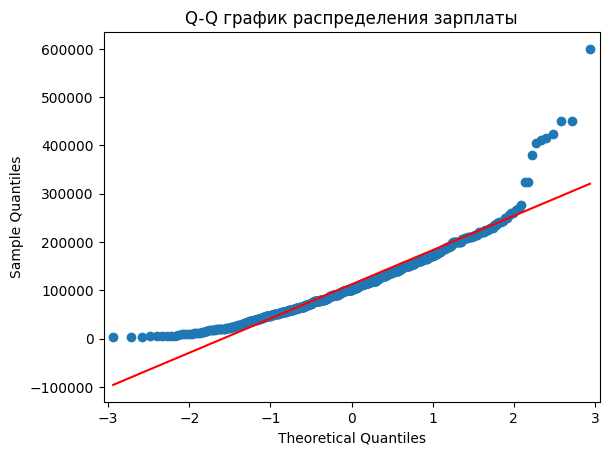

In [46]:
sm.qqplot(main_df['salary_in_usd'], line='s')
plt.title('Q-Q график распределения зарплаты')
plt.show()

### 2.2. Статистический анализ данных ###

In [27]:
# test_df = main_df[main_df.job_title == 'Data Scientist'].groupby(['job_title', 'work_year'])[['salary_in_usd']].mean()
test_df = main_df.groupby(['job_title', 'work_year'])[['salary_in_usd']].median()

display(test_df)

salary_in_usd
job_title      work_year               
Data Engineer  2020             74130.0
               2021             78416.5
               2022            120000.0
Data Scientist 2020             62726.0
               2021             73000.0
               2022            140000.0
Other          2020             86000.0
               2021             89647.0
               2022            112900.0

## 3. Бизнес-вопросы ##

### 3.1. Наблюдается ли ежегодный рост зарплат у специалистов **`Data Scientist`**? ###

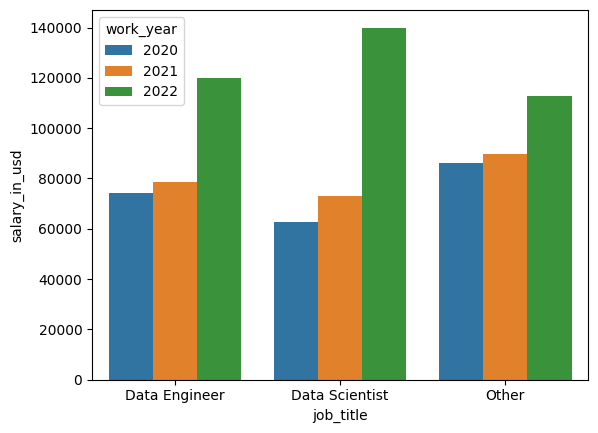

In [26]:
barplot = sns.barplot(
    data=test_df,
    x='job_title',
    y='salary_in_usd',
    hue='work_year'
)

### 3.2. Как соотносятся зарплаты **`Data Scientist`** и **`Data Engineer`** в 2022 году? ###

### 3.3. Как соотносятся зарплаты специалистов **`Data Scientist`** в компаниях различных размеров? ###

### 3.4. Есть ли связь между наличием должностей **`Data Scientist`** и **`Data Engineer`** и размером компании? ###

## 4. Дополнительное исследование ##

### 4.1. Правильно ли отбросили признак **`salary`**? ###

### 4.2. Если расширить роли **`Data Scientist`** и **`Data Engineer`**? ###